In [51]:
import PIL
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFilter
from torchvision import transforms
from torch import save
import h5py
import numpy as np

import time
import random
import json
import csv
import pathlib
from os import listdir
from os.path import isfile, join

all_settings = {
    'kanji' : {
        'script_name' : 'kanji',
        'filename':'./Symbols/kanji_array.json',
        'fonts' : [
            {'font_name':"meiryo.ttc", 'offset':-0.15}, #Requires japanese language to be added as a language in windows options
            {'font_name':"yumin.ttf", 'offset':0},
            {'font_name':"YuGothB.ttc", 'offset':0},
            {'font_name':"./Fonts/DelaGothicOne-Regular.ttf", 'offset':-0.25}
        ]
    },
    
    'hangul' : {
        'script_name' : 'hangul',
        'filename':'./Symbols/hangul_array.json',
        'fonts' : [
            {'font_name':'malgunbd.ttf', 'offset':-0.2},
            {'font_name':'malgun.ttf', 'offset':-0.2},
            {'font_name':'malgunsl.ttf', 'offset':-0.2},
        ]
    }
}
            
#settings = all_settings['kanji']
settings = all_settings['hangul']


In [52]:
symbol_array = []
with open(settings['filename'], mode='r',encoding="utf-8") as f:
    symbol_array = json.load(f)

def createImageRotations(pixelSize=64,symbol=u"魔",font=None, yBaseOffset=0,key=-1,foreground=(0,0,0,255),background=(255,255,255),angle=0,seed=0) -> Image:
    random.seed(seed)
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", 40)
    
    fontSize = font.size
    
    #randXOffset = random.randrange((font.size//4) + 1) - font.size//8
    #randYOffset = random.randrange((font.size//4) + 1) - font.size//8
    
    randXOffset = random.randrange(17)-8
    randYOffset = random.randrange(17)-8
    
    fontOffsetX = (pixelSize-fontSize)//2 + randXOffset
    fontOffsetY = yBaseOffset*fontSize +(pixelSize-fontSize)//2 + randYOffset
    
    perturbationOffset = fontSize
    
    
    
    image1 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
    background1 = Image.new(mode='L', size = (pixelSize,pixelSize), color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
    sampling = PIL.Image.Resampling.BICUBIC
    
    image_rot = background1.copy()
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling).split()[-1])
    
    #Add perturbations
    
    if random.randrange(2) == 0:
        #print("Success")
        
        decider = random.randrange(4)
        x = -1 if decider==0 else (1 if decider==1 else 0)
        y = -1 if decider==2 else (1+(yBaseOffset*0.7) if decider==3 else 0)
        
        n_symbol = random.randrange(len(symbol_array))
        symbolPerturbation = symbol_array[n_symbol]
        
        image2 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
        draw2 = ImageDraw.Draw(image2)
        draw2.text((fontOffsetX + x*perturbationOffset , fontOffsetY + y*perturbationOffset), symbolPerturbation, foreground, font=font)
        image_rot.paste(image2.rotate(angle,sampling), (0, 0), image2.rotate(angle,sampling).split()[-1])
    
    if random.randrange(3) == 0:
        image_rot = image_rot.filter(ImageFilter.GaussianBlur(radius = fontSize//20))
    
    #image_rot.show()
    return image_rot

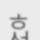

In [53]:
tempFont = ImageFont.truetype("malgunsl.ttf", 25)
T = transforms.ToTensor()
reverseT = transforms.ToPILImage()
img1 = createImageRotations(
    pixelSize=40,
    symbol=u"ㅎ",
    font=tempFont,
    yBaseOffset=-0.2,
    key=-1,
    foreground=(30,255),
    background=(235),
    angle=0,
    seed=4 
    #4 has a symbol lower down
    #13 has a symbol on the right
)
#print(np.asarray(img1).astype(np.ubyte))
img1
#(255*np.asarray(img1)).astype(np.byte)

In [54]:
color_settings = [
    {'foreground':(0,255), 'background':(255)},
    {'foreground':(255,255), 'background':(0)},
    {'foreground':(90,255), 'background':(235)},
    {'foreground':(235,255), 'background':(90)}
]

rotations = [10,0,-10]

fontSizes = [0.625,0.875,1.25]

def createImage2(file,pixelSize=64,symbol=u"魔",key=-1):
    #fontSize = math.ceil(pixelSize*0.78)
    #fontOffsetX = math.floor(pixelSize*0.22/2)
    #fontOffsetY = math.floor(pixelSize*0.22/4)
    
    to_tensor = transforms.ToTensor()
    
    num_iter = 0
    for size in fontSizes:
        fontSize = math.floor(size*pixelSize)
        fonts = [
            {
            'font_value' : ImageFont.truetype(settings['fonts'][index]['font_name'], fontSize), 
            'offset' : settings['fonts'][index]['offset']
            } 
            for index in range(len(settings['fonts']))
        ]
        """
        fonts = [
            {'font_value':ImageFont.truetype("meiryo.ttc", fontSize), 'offset':-0.15}, #Requires japanese language to be added as a language in windows options
            {'font_value':ImageFont.truetype("yumin.ttf", fontSize), 'offset':0},
            {'font_value':ImageFont.truetype("YuGothB.ttc", fontSize), 'offset':0},
            {'font_value':ImageFont.truetype("./Fonts/DelaGothicOne-Regular.ttf", fontSize), 'offset':-0.25}
            #ImageFont.truetype("YuGothM.ttc", fontSize),
            #ImageFont.truetype("msmincho.ttc", fontSize)
        ]
        """
        
        for font_obj in fonts:
            for color_setting in color_settings:
                for rotation in rotations:

                    num_iter += 1

                    fore = color_setting['foreground']
                    back = color_setting['background']
                    
                    font = font_obj['font_value']
                    fontYOffset = font_obj['offset']
                    
                    image1 = createImageRotations(
                        pixelSize=pixelSize,
                        symbol=symbol,
                        font=font,
                        yBaseOffset=fontYOffset,
                        key=key,
                        foreground=fore,
                        background=color_setting['background'],
                        angle=rotation,
                        seed=key*num_iter
                    )

                    #filename = u"./Training_set/"+str(key) +"_"+ symbol +"_"+ font.getname()[0] +"_"+ font.getname()[1]  +"_fore("+ str(fore[0]) + ")_back("+ str(back[0]) + ")_rot(" + str(rotation) + ")"
                    filename = u"./Image_set/"+str(key) +"_"+ symbol +"_"+ str(num_iter) +"_"+ font.getname()[0] +"_"+ font.getname()[1]
                    
                    np_array = np.asarray(image1).astype(np.ubyte)
                    
                    isEval = random.randrange(4)==0
                    group = 'evaluation_group' if isEval else 'training_group'
                    
                    dataset = f[group]['dataset']
                    labels = f[group]['labels']
                    
                    if not dataset.attrs['empty']:
                        dataset.resize(1+dataset.shape[0],axis=0)
                        labels.resize(1+labels.shape[0],axis=0)
                    
                    dataset.attrs['empty'] = False
                    labels.attrs['empty'] = False
                    dataset[-1] = np_array
                    labels[-1] = key
    

In [55]:

picturesAsTensors = True
pixelSize = 64

with open(settings['filename'], mode='r',encoding="utf-8") as f:
    symbol_array = json.load(f)
    random.seed(420)
    
    with h5py.File('image_set_' + settings['script_name'] + '.hdf5', mode='w') as f:
    
        train_group = f.create_group("training_group")
        eval_group = f.create_group("evaluation_group")
        t_set = train_group.create_dataset("dataset", dtype=np.ubyte, data=np.zeros([1,pixelSize,pixelSize]),maxshape=(None, pixelSize, pixelSize))
        t_lab = train_group.create_dataset("labels", dtype=np.intc, data=np.zeros([1,1]),maxshape=(None,1))
        e_set = eval_group.create_dataset("dataset", dtype=np.ubyte, data=np.zeros([1,pixelSize,pixelSize]),maxshape=(None, pixelSize, pixelSize))
        e_lab = eval_group.create_dataset("labels", dtype=np.intc, data=np.zeros([1,1]),maxshape=(None,1))
        
        t_set.attrs['empty'] = True
        t_lab.attrs['empty'] = True
        e_set.attrs['empty'] = True
        e_lab.attrs['empty'] = True
        
        start = time.time()
        for index in range(len(symbol_array)):
            
            symbol = symbol_array[index]
            key = index
            createImage2(file=f, pixelSize=pixelSize, symbol=symbol, key=key)
            if index%50==49:
                end = time.time()
                ratio = index/len(symbol_array)
                dt = end-start
                expected_time = math.floor(dt*((1-ratio)/ratio))

                percent = 100*ratio
                percent = math.floor(100*percent)/100
                print(str(percent)+"% of pictures generated. Estimated time left : " 
                      + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
print("100% of pictures generated.")

2.41% of pictures generated. Estimated time left : 5m 18s
4.88% of pictures generated. Estimated time left : 5m 13s
7.34% of pictures generated. Estimated time left : 5m 4s
9.81% of pictures generated. Estimated time left : 4m 57s
12.27% of pictures generated. Estimated time left : 4m 50s
14.74% of pictures generated. Estimated time left : 4m 42s
17.2% of pictures generated. Estimated time left : 4m 33s
19.67% of pictures generated. Estimated time left : 4m 25s
22.14% of pictures generated. Estimated time left : 4m 17s
24.6% of pictures generated. Estimated time left : 4m 10s
27.07% of pictures generated. Estimated time left : 4m 3s
29.53% of pictures generated. Estimated time left : 3m 55s
32.0% of pictures generated. Estimated time left : 3m 46s
34.46% of pictures generated. Estimated time left : 3m 38s
36.93% of pictures generated. Estimated time left : 3m 30s
39.39% of pictures generated. Estimated time left : 3m 22s
41.86% of pictures generated. Estimated time left : 3m 13s
44.32%